<a href="https://colab.research.google.com/github/ved8696/Master-Thesis/blob/main/Thesis_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [2]:
!pwd

/content


In [4]:
cd /content/drive/My Drive/Word Sense Disambiguation BILSTM/Word-Sense-Disambiguation-using-Bidirectional-LSTM/

/content/drive/My Drive/Word Sense Disambiguation BILSTM/Word-Sense-Disambiguation-using-Bidirectional-LSTM


In [5]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [6]:
!pip install keras-self-attention



  Created wheel for keras-self-attention: filename=keras_self_attention-0.50.0-py3-none-any.whl size=19414 sha256=9d6f305816856abacf7afa29b1c5fa213b0a560785a3f4cc5e069e0c956e5172
  Stored in directory: /root/.cache/pip/wheels/92/7a/a3/231bef5803298e7ec1815215bc0613239cb1e9c03c57b13c14
Successfully built keras-self-attention


In [7]:
import keras
from keras_self_attention import SeqSelfAttention

In [8]:
from data import *
from glove import *
import tensorflow as tf
from tensorflow.python import keras
#import tensorflow.nn.rnn_cell as rnn_cell
from tensorflow.keras.layers import RNN
from sklearn.model_selection import train_test_split
import os
import glob
import numpy as np
import h5py
import matplotlib.pyplot as plt
from keras.layers import Layer
import keras.backend as K

from random import random
from numpy import array
from numpy import cumsum
from matplotlib import pyplot
from pandas import DataFrame

import keras
from keras_self_attention import SeqSelfAttention
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GlobalAveragePooling1D, TimeDistributed, GlobalMaxPooling1D, BatchNormalization
from keras.layers.merge import concatenate
from keras.models import Model
from tensorflow.keras.models import Sequential
import keras.layers.normalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
import keras.backend as K
from keras.utils.vis_utils import plot_model



In [9]:
#!git clone https://github.com/google-research-datasets/word_sense_disambigation_corpora.git

In [10]:
#Train Data

train_data_ = load_train_data(23)
EMBEDDING_DIM = 100
# build vocab utils
word_to_id = build_vocab(train_data_)
target_word_to_id, target_sense_to_id, n_words, n_senses_from_target_id = build_sense_ids(train_data_)
#build context vocab of the target sense
train_target_sense_to_context = build_context(train_data_, word_to_id)
#build context embeddings of the target sense
embedding_matrix = fill_with_gloves(word_to_id, 100)
target_sense_to_context_embedding = build_embedding(train_target_sense_to_context, embedding_matrix, len(word_to_id), EMBEDDING_DIM)
# make numeric
train_ndata = convert_to_numeric(train_data_, word_to_id, target_word_to_id, target_sense_to_id, n_senses_from_target_id, target_sense_to_context_embedding, is_training = True)




n words not found in glove word vectors: 12113


In [11]:
n_step_f = 40
n_step_b = 40
print('n_step forward/backward: %d / %d' % (n_step_f, n_step_b))

MAX_SEQUENCE_LENGTH = 40
act = 'relu'

n_step forward/backward: 40 / 40


In [12]:
def final_data(data, n_step_f, n_step_b):
  forward_data, backward_data, target_sense_ids, sense_embeddings = [], [], [], []
  for instance in data:
      #xf, xb, target_sense_id, sense_embedding = instance.xf, instance.xb, instance.id, instance.sense_embedding
      xf, xb, target_sense_id, sense_embedding = instance[0], instance[1], instance[2], instance[3]
            
      n_to_use_f = min(n_step_f, len(xf))
      n_to_use_b = min(n_step_b, len(xb))
      xfs = np.zeros([n_step_f], dtype=np.int32)
      xbs = np.zeros([n_step_b], dtype=np.int32)            
      if n_to_use_f != 0:
        xfs[-n_to_use_f:] = xf[-n_to_use_f:]
      if n_to_use_b != 0:
        xbs[-n_to_use_b:] = xb[-n_to_use_b:]
            
      forward_data.append(xfs)
      backward_data.append(xbs)
      target_sense_ids.append(target_sense_id)
      sense_embeddings.append(sense_embedding)
  return (np.array(forward_data), np.array(backward_data), np.array(target_sense_ids), np.array(sense_embeddings))

In [13]:
init_emb = fill_with_gloves(word_to_id, EMBEDDING_DIM)

n words not found in glove word vectors: 12113


In [14]:
train_forward_data, train_backward_data, train_target_sense_ids, train_sense_embedding = final_data(train_ndata, n_step_f, n_step_b)

In [15]:
train_sense_embedding.shape

(16216, 100)

In [16]:
train_forward_data, val_forward_data = train_test_split(train_forward_data, test_size=0.1, shuffle=False)
train_backward_data, val_backward_data = train_test_split(train_backward_data, test_size=0.1, shuffle=False)
train_target_sense_ids, val_target_sense_data = train_test_split(train_target_sense_ids, test_size=0.1, shuffle=False)
train_sense_embedding, val_sense_embedding = train_test_split(train_sense_embedding, test_size=0.1, shuffle=False)

In [17]:
train_forward_data, test_forward_data = train_test_split(train_forward_data, test_size=0.11, shuffle=False)
train_backward_data, test_backward_data = train_test_split(train_backward_data, test_size=0.11, shuffle=False)
train_target_sense_ids, test_target_sense_data = train_test_split(train_target_sense_ids, test_size=0.11, shuffle=False)
train_sense_embedding, test_sense_embedding = train_test_split(train_sense_embedding, test_size=0.11, shuffle=False)

In [18]:
def cos_distance(y_true, y_pred):
    y_true = K.l2_normalize(y_true, axis=-1)
    y_pred = K.l2_normalize(y_pred, axis=-1)
    return K.mean(1 - K.sum((y_true * y_pred), axis=-1))

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives +K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


def own_model(train_forward_data, train_backward_data, train_sense_embedding, 
              val_forward_data=None, val_backward_data=None, val_sense_embedding=None,
              n_units=100, dense_unints=256, is_training=True, EMBEDDING_DIM=100, epochs=10, batch_size=512, init_word_vecs=None):
    
    embedding_layer = Embedding(len(word_to_id),
                                EMBEDDING_DIM,
                                weights=[init_word_vecs],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)
    lstm_layer = LSTM(n_units, dropout=0.2, recurrent_dropout=0.2)
    forward_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32', name='forward_input')
    embedded_forward = embedding_layer(forward_input)
    forward_lstm = lstm_layer(embedded_forward)
        
    backward_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32', name='backward_input')
    embedded_backward = embedding_layer(backward_input)
    backward_lstm = lstm_layer(embedded_backward)
    
    merged = concatenate([forward_lstm, backward_lstm])     
    
    
    merged = Dropout(0.2)(merged) if is_training else merged
    #merged = BatchNormalization()(merged)


    merged = Dense(units=dense_unints, activation=act)(merged)
    merged = Dropout(0.2)(merged) if is_training else merged
    #merged = BatchNormalization()(merged)
    #merged = Dropout(0.2)(merged) if is_training else merged
    merged = BatchNormalization()(merged)
    
    preds_final = Dense(EMBEDDING_DIM, activation='softmax')(merged)
    
    ## train the model 
    model = Model(inputs=[forward_input, backward_input], outputs=preds_final)

    model.compile(loss='mse', optimizer='rmsprop', metrics=['acc', cos_distance, f1_m])
    
    model.summary()
    plot_model(model, to_file='./Images/model_plot_bilstm.png', show_shapes=True, show_layer_names=True)
    early_stopping =EarlyStopping(monitor='val_acc', mode='max', patience=10)
    #bst_model_path = STAMP + '.h5'
    bst_model_path = "weights.best.hdf5"
    model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True, verbose=1)
      
    hist = model.fit([train_forward_data, train_backward_data], train_sense_embedding, 
                     validation_data=([val_forward_data, val_backward_data], val_sense_embedding), 
                     epochs=epochs, batch_size=batch_size, shuffle=True, 
                     callbacks=[early_stopping, model_checkpoint])
    
    model.load_weights(bst_model_path)
    model.evaluate([test_forward_data, test_backward_data], test_sense_embedding)
    model_predict = model.predict([test_forward_data, test_backward_data])
    bst_val_score = min(hist.history['val_acc'])
    print(hist.history.keys())
    print('min val acc is: %f' % (bst_val_score))
    fig = plt.figure()
    plt.plot(hist.history["loss"], label="Training Loss")
    plt.plot(hist.history["val_acc"], label="Validation Loss")
    plt.plot(hist.history["val_acc"], label="Validation Accuracy")
    plt.plot(hist.history["acc"], label="Accuracy")
    plt.legend()
    plt.show()
    fig.savefig('./Images/bilstm.png')
    return model_predict


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
forward_input (InputLayer)      [(None, 40)]         0                                            
__________________________________________________________________________________________________
backward_input (InputLayer)     [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 100)      6429900     forward_input[0][0]              
                                                                 backward_input[0][0]             
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 100)          80400       embedding[0][0]              

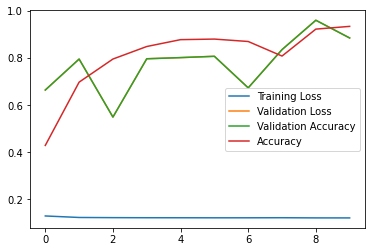

In [19]:

model_predict = own_model(train_forward_data, train_backward_data, train_sense_embedding, 
              val_forward_data, val_backward_data, val_sense_embedding, 
              init_word_vecs=init_emb)

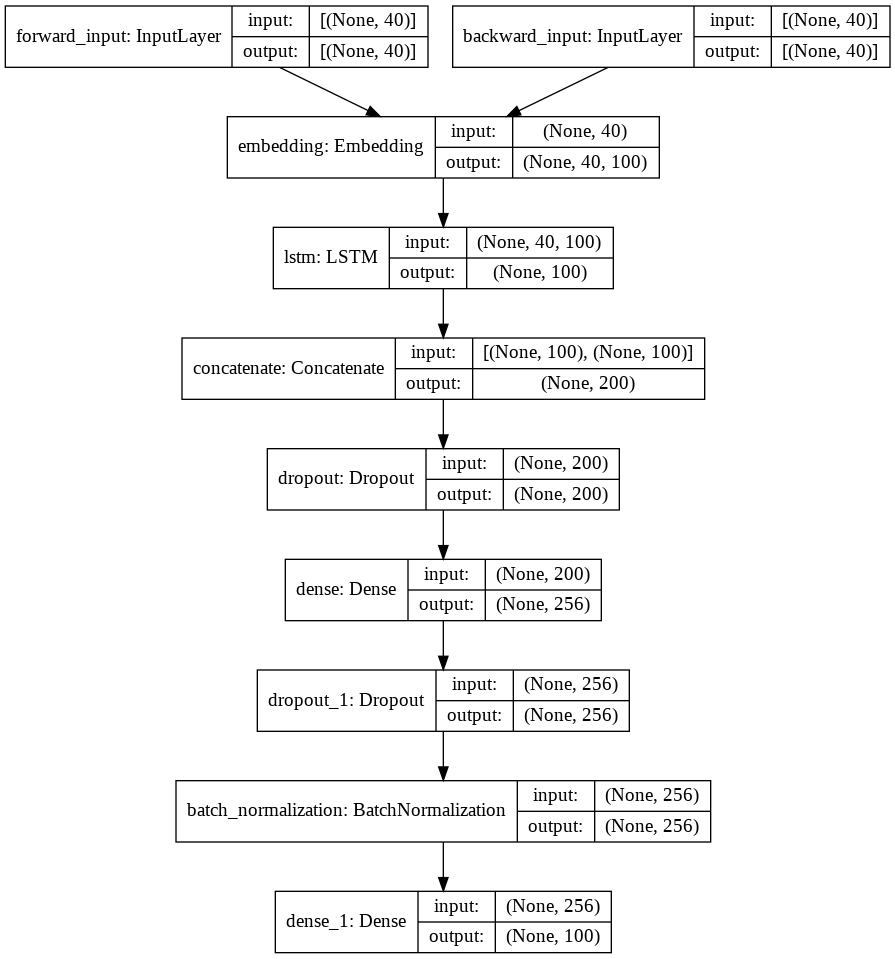

In [20]:
from IPython.display import Image
Image('./Images/model_plot_bilstm.png')

In [21]:
from sklearn.manifold import TSNE 
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, output_file
output_notebook()
import pandas as pd
import seaborn as sns

In [22]:
def plot_predicted(data, test_target_sense_data):
  tsne = TSNE(n_components=2, random_state=0)
  tsne_pred = tsne.fit_transform(data)

  x = tsne_pred[:,0]
  y = tsne_pred[:,1]
  sense = test_target_sense_data
  sense_embedding_space = pd.DataFrame(
      {'x': x,
      'y': y, 
      'sense': sense
      })

  p = figure(title="Fashion")

  source = ColumnDataSource(data=dict(x1=tsne_pred[:,0],
                                      x2=tsne_pred[:,1], 
                                      names=tsne_pred))

  p.scatter(x="x1", y="x2",size=8, source=source)
  show(p)

  g = sns.lmplot(x = 'x', y = 'y', data=sense_embedding_space, hue='sense', palette=sns.color_palette("bright"), fit_reg=False)
  g._legend.remove()

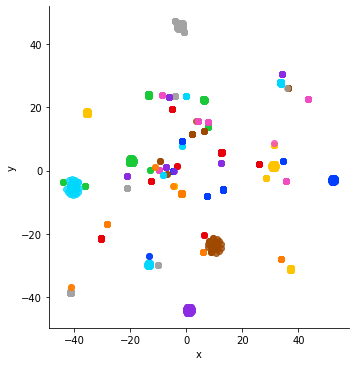

In [23]:
plot_predicted(test_sense_embedding, test_target_sense_data)

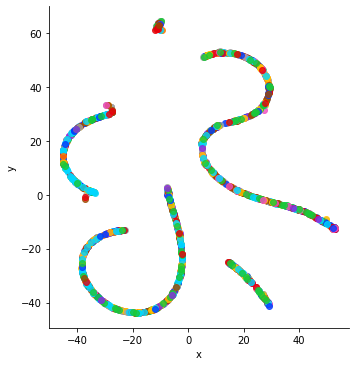

In [24]:
plot_predicted(model_predict, test_target_sense_data)

In [25]:
def atten_model(train_forward_data, train_backward_data, train_sense_embedding, 
              val_forward_data=None, val_backward_data=None, val_sense_embedding=None,
              n_units=100, dense_unints=256, is_training=True, EMBEDDING_DIM=100, epochs=50, batch_size=512, init_word_vecs=None):
    
    embedding_layer = Embedding(len(word_to_id),
                                EMBEDDING_DIM,
                                weights=[init_word_vecs],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)
    lstm_layer = LSTM(n_units, dropout=0.2, recurrent_dropout=0.2, return_sequences = True)
    forward_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32', name='forward_input')
    embedded_forward = embedding_layer(forward_input)
    forward_lstm = lstm_layer(embedded_forward)

    
    backward_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32', name='backward_input')
    embedded_backward = embedding_layer(backward_input)
    backward_lstm = lstm_layer(embedded_backward)
    
    merged = concatenate([forward_lstm, backward_lstm])     


    merged = Dropout(0.2)(merged) if is_training else merged
    merged = BatchNormalization()(merged)
    merged = SeqSelfAttention(attention_activation='sigmoid')(merged)
    merged = TimeDistributed(Dense(units=dense_unints, activation=act))(merged)
    merged = Dropout(0.2)(merged) if is_training else merged
    merged = BatchNormalization()(merged)
    merged = GlobalAveragePooling1D()(merged)
  
    preds = Dense(EMBEDDING_DIM, activation='softmax')(merged)

    
    ## train the model 
    model = Model(inputs=[forward_input, backward_input], outputs=preds)


    model.compile(loss='mse', optimizer='rmsprop', metrics=['acc',cos_distance, f1_m])
    
    model.summary()
    plot_model(model, to_file='./Images/model_bilstm_atten.png', show_shapes=True, show_layer_names=True)
    early_stopping =EarlyStopping(monitor='val_acc', mode='max', patience=10)
    #bst_model_path = STAMP + '.h5'
    bst_model_path = "weights.best.hdf5"
    model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True, verbose=1)
      
    hist = model.fit([train_forward_data, train_backward_data], train_sense_embedding, 
                     validation_data=([val_forward_data, val_backward_data], val_sense_embedding), 
                     epochs=epochs, batch_size=batch_size, shuffle=True, 
                     callbacks=[early_stopping, model_checkpoint])
    
    model.load_weights(bst_model_path)
    model.evaluate([test_forward_data, test_backward_data], test_sense_embedding)
    model_predict = model.predict([test_forward_data, test_backward_data])
    bst_val_score = min(hist.history['val_acc'])
    print(hist.history.keys())
    print('min val acc is: %f' % (bst_val_score))
    fig = plt.figure()
    plt.plot(hist.history["loss"], label="Training Loss")
    plt.plot(hist.history["val_acc"], label="Validation Loss")
    plt.plot(hist.history["val_acc"], label="Validation Accuracy")
    plt.plot(hist.history["acc"], label="Accuracy")
    plt.legend()
    plt.show()
    fig.savefig('./Images/bilstm+att.png')
    return model_predict

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
forward_input (InputLayer)      [(None, 40)]         0                                            
__________________________________________________________________________________________________
backward_input (InputLayer)     [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 100)      6429900     forward_input[0][0]              
                                                                 backward_input[0][0]             
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 40, 100)      80400       embedding_1[0][0]          

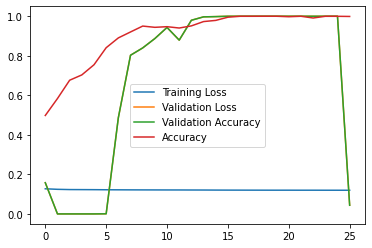

In [26]:

model_predict_atten = atten_model(train_forward_data, train_backward_data, train_sense_embedding, 
              val_forward_data, val_backward_data, val_sense_embedding, 
              init_word_vecs=init_emb)

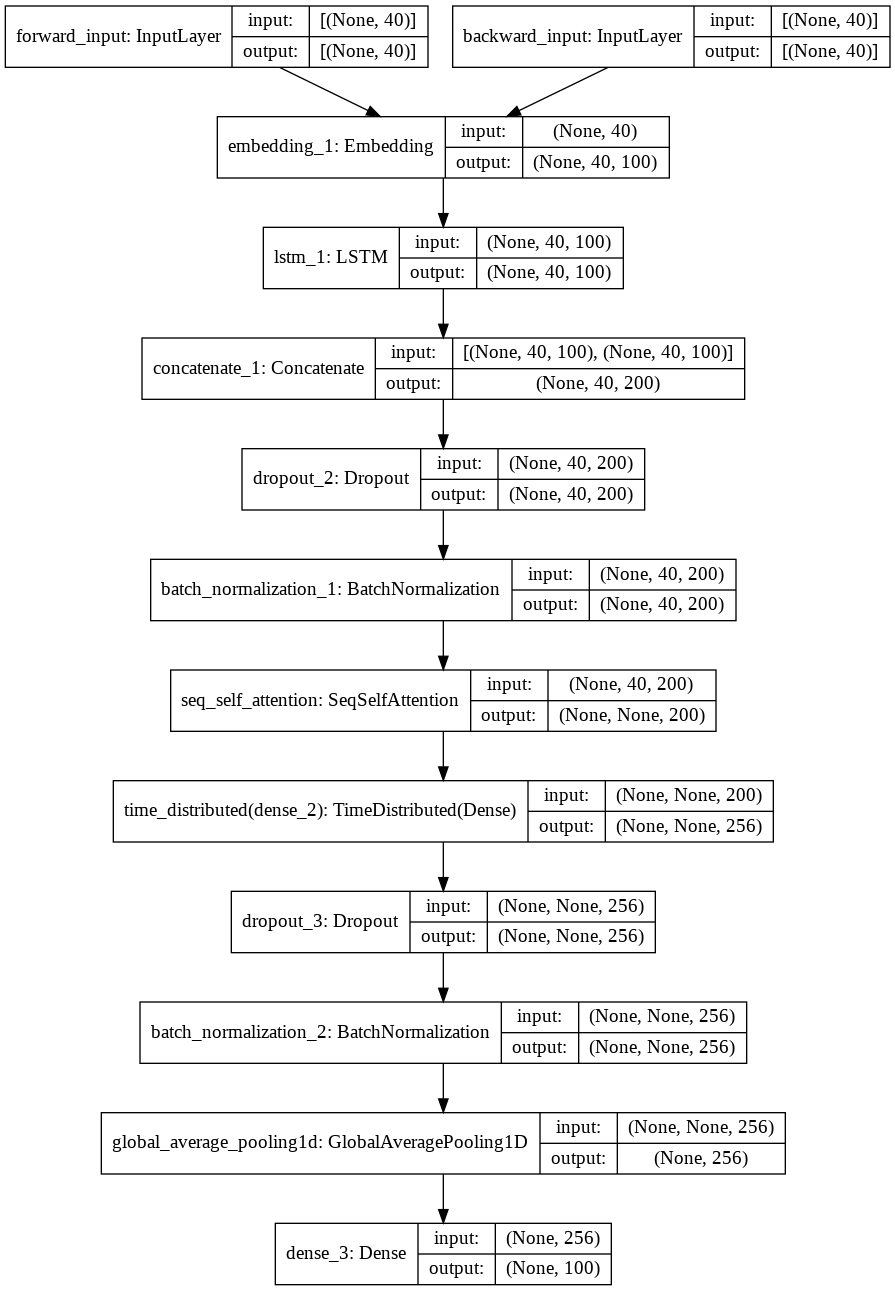

In [27]:
from IPython.display import Image
Image('./Images/model_bilstm_atten.png')

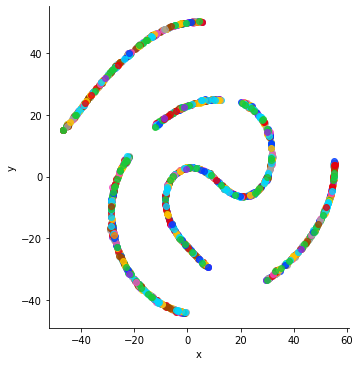

In [28]:
plot_predicted(model_predict_atten, test_target_sense_data)

In [29]:
def at_lstm_model(train_forward_data, train_backward_data, train_sense_embedding, 
              val_forward_data=None, val_backward_data=None, val_sense_embedding=None,
              n_units=100, dense_unints=256, is_training=True, EMBEDDING_DIM=100, epochs=50, batch_size=512, init_word_vecs=None):
    
    embedding_layer = Embedding(len(word_to_id),
                                EMBEDDING_DIM,
                                weights=[init_word_vecs],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)
    lstm_layer = LSTM(n_units, dropout=0.2, recurrent_dropout=0.2, return_sequences = True)
    forward_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32', name='forward_input')
    embedded_forward = embedding_layer(forward_input)
    forward_lstm = lstm_layer(embedded_forward)
    forward_lstm = SeqSelfAttention(attention_activation='sigmoid')(forward_lstm)
    
    backward_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32', name='backward_input')
    embedded_backward = embedding_layer(backward_input)
    backward_lstm = lstm_layer(embedded_backward)
    backward_lstm = SeqSelfAttention(attention_activation='sigmoid')(backward_lstm)
    merged = concatenate([forward_lstm, backward_lstm])     

    merged = Dropout(0.2)(merged) if is_training else merged
    merged = BatchNormalization()(merged)
    merged = TimeDistributed(Dense(units=dense_unints, activation=act))(merged)
    merged = Dropout(0.2)(merged) if is_training else merged
    merged = BatchNormalization()(merged)
    merged = GlobalAveragePooling1D()(merged)
    #merged = Dense(units=dense_unints, activation=act)(merged)
    #merged = Dropout(0.2)(merged) if is_training else merged
    #merged = BatchNormalization()(merged)    
    preds = Dense(EMBEDDING_DIM, activation='softmax')(merged)

    
    ## train the model 
    model = Model(inputs=[forward_input, backward_input], outputs=preds)

 
    model.compile(loss='mse', optimizer='rmsprop', metrics=['acc',cos_distance, f1_m])
    
    model.summary()
    plot_model(model, to_file='./Images/model_at_lstm.png', show_shapes=True, show_layer_names=True)
    early_stopping =EarlyStopping(monitor='val_acc', mode='max', patience=10)
    #bst_model_path = STAMP + '.h5'
    bst_model_path = "weights.best.hdf5"
    model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True, verbose=1)
      
    hist = model.fit([train_forward_data, train_backward_data], train_sense_embedding, 
                     validation_data=([val_forward_data, val_backward_data], val_sense_embedding), 
                     epochs=epochs, batch_size=batch_size, shuffle=True, 
                     callbacks=[early_stopping, model_checkpoint])
    
    model.load_weights(bst_model_path)
    model.evaluate([test_forward_data, test_backward_data], test_sense_embedding)
    model_predict = model.predict([test_forward_data, test_backward_data])
    bst_val_score = min(hist.history['val_acc'])
    print(hist.history.keys())
    print('min val acc is: %f' % (bst_val_score))
    fig = plt.figure()
    plt.plot(hist.history["loss"], label="Training Loss")
    plt.plot(hist.history["val_acc"], label="Validation Loss")
    plt.plot(hist.history["val_acc"], label="Validation Accuracy")
    plt.plot(hist.history["acc"], label="Accuracy")
    plt.legend()
    plt.show()
    fig.savefig('./Images/atten_lstm.png')
    return model_predict


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
forward_input (InputLayer)      [(None, 40)]         0                                            
__________________________________________________________________________________________________
backward_input (InputLayer)     [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 40, 100)      6429900     forward_input[0][0]              
                                                                 backward_input[0][0]             
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 40, 100)      80400       embedding_2[0][0]          

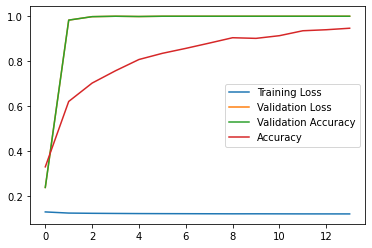

In [30]:

model_at_lstm = at_lstm_model(train_forward_data, train_backward_data, train_sense_embedding, 
              val_forward_data, val_backward_data, val_sense_embedding, 
              init_word_vecs=init_emb)

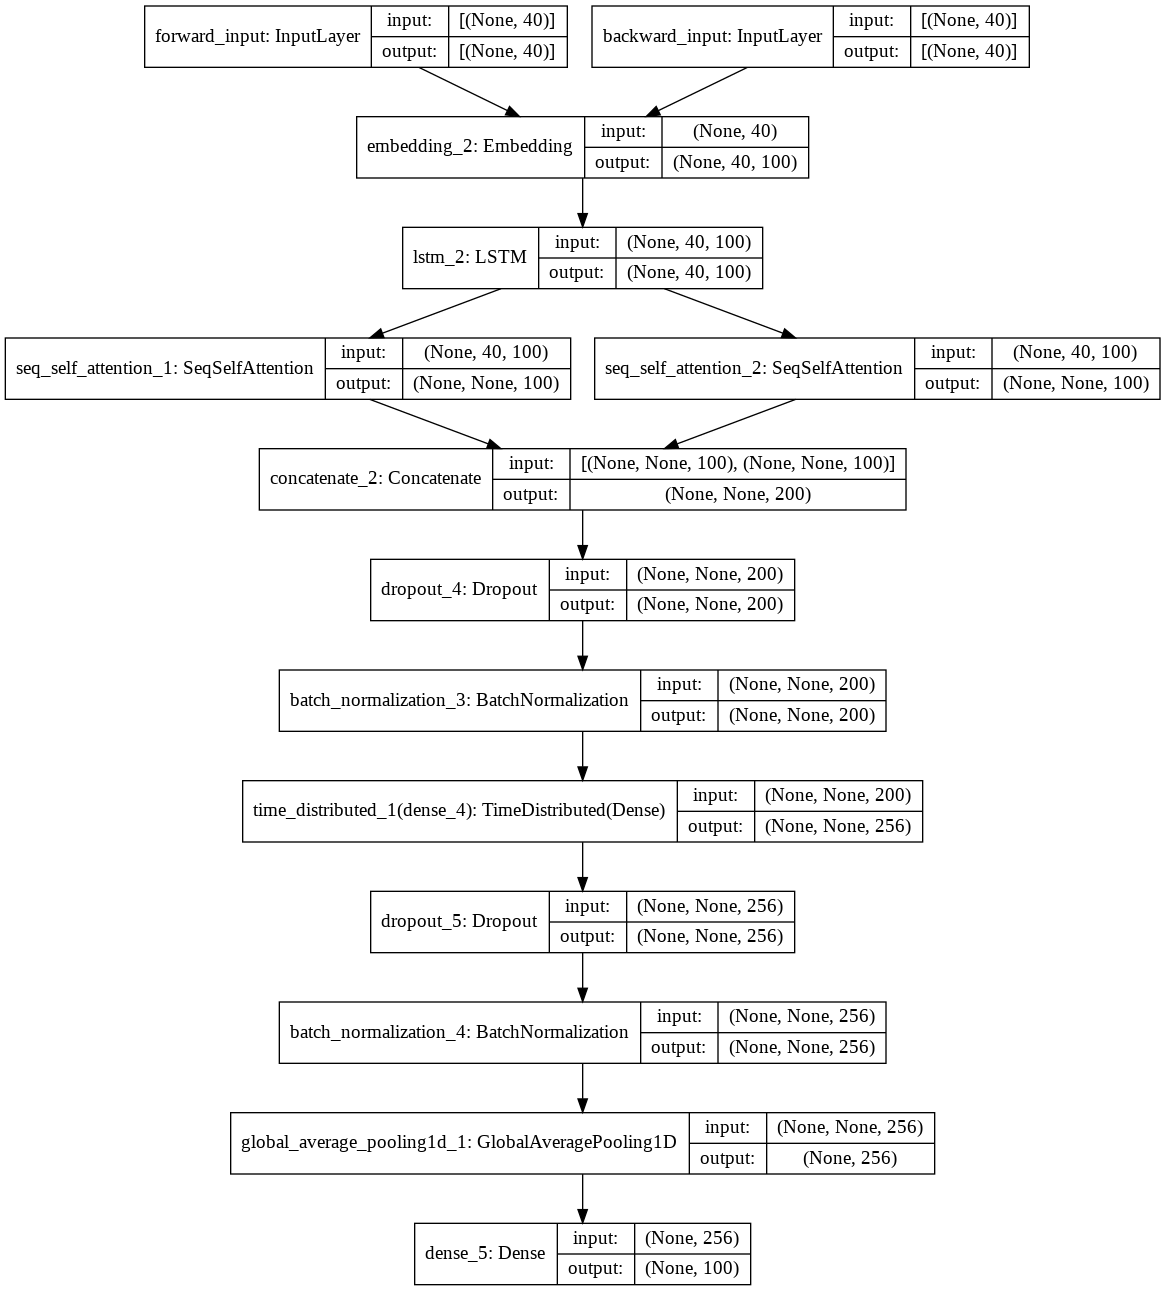

In [31]:
from IPython.display import Image
Image('./Images/model_at_lstm.png')

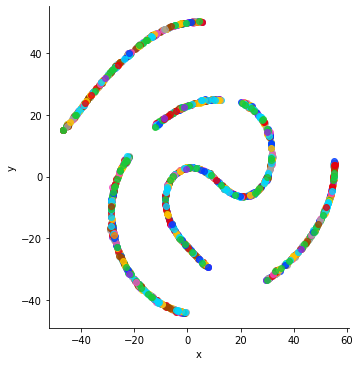

In [32]:
plot_predicted(model_predict_atten, test_target_sense_data)

In [33]:
def seq2seq_model(train_forward_data, train_backward_data, train_sense_embedding, 
              val_forward_data=None, val_backward_data=None, val_sense_embedding=None,
              n_units=100, dense_unints=256, is_training=True, EMBEDDING_DIM=100, epochs=50, batch_size=512, init_word_vecs=None):
    
    embedding_layer = Embedding(len(word_to_id),
                                EMBEDDING_DIM,
                                weights=[init_word_vecs],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)
    lstm_layer = LSTM(n_units, dropout=0.2, recurrent_dropout=0.2, return_sequences = True, return_state = True)
    lstm_layer_forward = LSTM(units=200, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, return_state = True)
    lstm_layer_backward = LSTM(units=200, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, return_state = True, go_backwards=True)
    forward_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32', name='forward_input')
    embedded_forward = embedding_layer(forward_input)
    forward_lstm, forward_h, forward_c = lstm_layer(embedded_forward)

    
    backward_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32', name='backward_input')
    embedded_backward = embedding_layer(backward_input)
    backward_lstm, backward_h, backward_c = lstm_layer(embedded_backward)
    
    merged_outputs = concatenate([forward_lstm, backward_lstm])
    state_h = concatenate([forward_h, backward_h])
    state_c = concatenate([forward_c, backward_c])
    encoder_state = [state_h, state_c]

    encoder_attention = SeqSelfAttention(attention_activation='sigmoid')(merged_outputs)
    
    decoder_forward, _, _ = lstm_layer_forward(encoder_attention, initial_state= [state_h, state_c])
    decoder_backward, _, _ = lstm_layer_backward(decoder_forward)
    decoder_bi = concatenate([decoder_forward, decoder_backward])
    merged = TimeDistributed(Dense(units=dense_unints, activation=act))(decoder_bi)
    merged = Dropout(0.2)(merged) if is_training else merged
    merged = BatchNormalization()(merged)
    merged = GlobalAveragePooling1D()(merged)
    #merged = Dense(units=dense_unints, activation=act)(merged)
    #merged = Dropout(0.2)(merged) if is_training else merged
    #merged = BatchNormalization()(merged)    
    preds = Dense(EMBEDDING_DIM, activation='softmax')(merged)

    
    ## train the model 
    model = Model(inputs=[forward_input, backward_input], outputs=preds)

    model.compile(loss='mse', optimizer='rmsprop', metrics=['acc',cos_distance, f1_m])
    
    model.summary()
    plot_model(model, to_file='./Images/model_plot_seq.png', show_shapes=True, show_layer_names=True)
    early_stopping =EarlyStopping(monitor='val_acc', mode='max', patience=10)
    #bst_model_path = STAMP + '.h5'
    bst_model_path = "weights.best.hdf5"
    model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True, verbose=1)
      
    hist = model.fit([train_forward_data, train_backward_data], train_sense_embedding, 
                     validation_data=([val_forward_data, val_backward_data], val_sense_embedding), 
                     epochs=epochs, batch_size=batch_size, shuffle=True, 
                     callbacks=[early_stopping, model_checkpoint])
    
    model.load_weights(bst_model_path)
    model.evaluate([test_forward_data, test_backward_data], test_sense_embedding)
    model_predict = model.predict([test_forward_data, test_backward_data])
    bst_val_score = min(hist.history['val_acc'])
    print(hist.history.keys())
    print('min val acc is: %f' % (bst_val_score))
    fig = plt.figure()
    plt.plot(hist.history["loss"], label="Training Loss")
    plt.plot(hist.history["val_acc"], label="Validation Loss")
    plt.plot(hist.history["val_acc"], label="Validation Accuracy")
    plt.plot(hist.history["acc"], label="Accuracy")
    plt.legend()
    plt.show()
    fig.savefig('./Images/seq2seq.png')
    return model_predict

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
forward_input (InputLayer)      [(None, 40)]         0                                            
__________________________________________________________________________________________________
backward_input (InputLayer)     [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 40, 100)      6429900     forward_input[0][0]              
                                                                 backward_input[0][0]             
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 40, 100), (N 80400       embedding_3[0][0]          

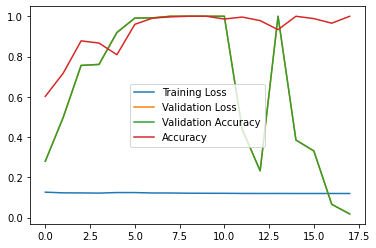

In [34]:

model_predict_seq = seq2seq_model(train_forward_data, train_backward_data, train_sense_embedding, 
              val_forward_data, val_backward_data, val_sense_embedding, 
              init_word_vecs=init_emb)

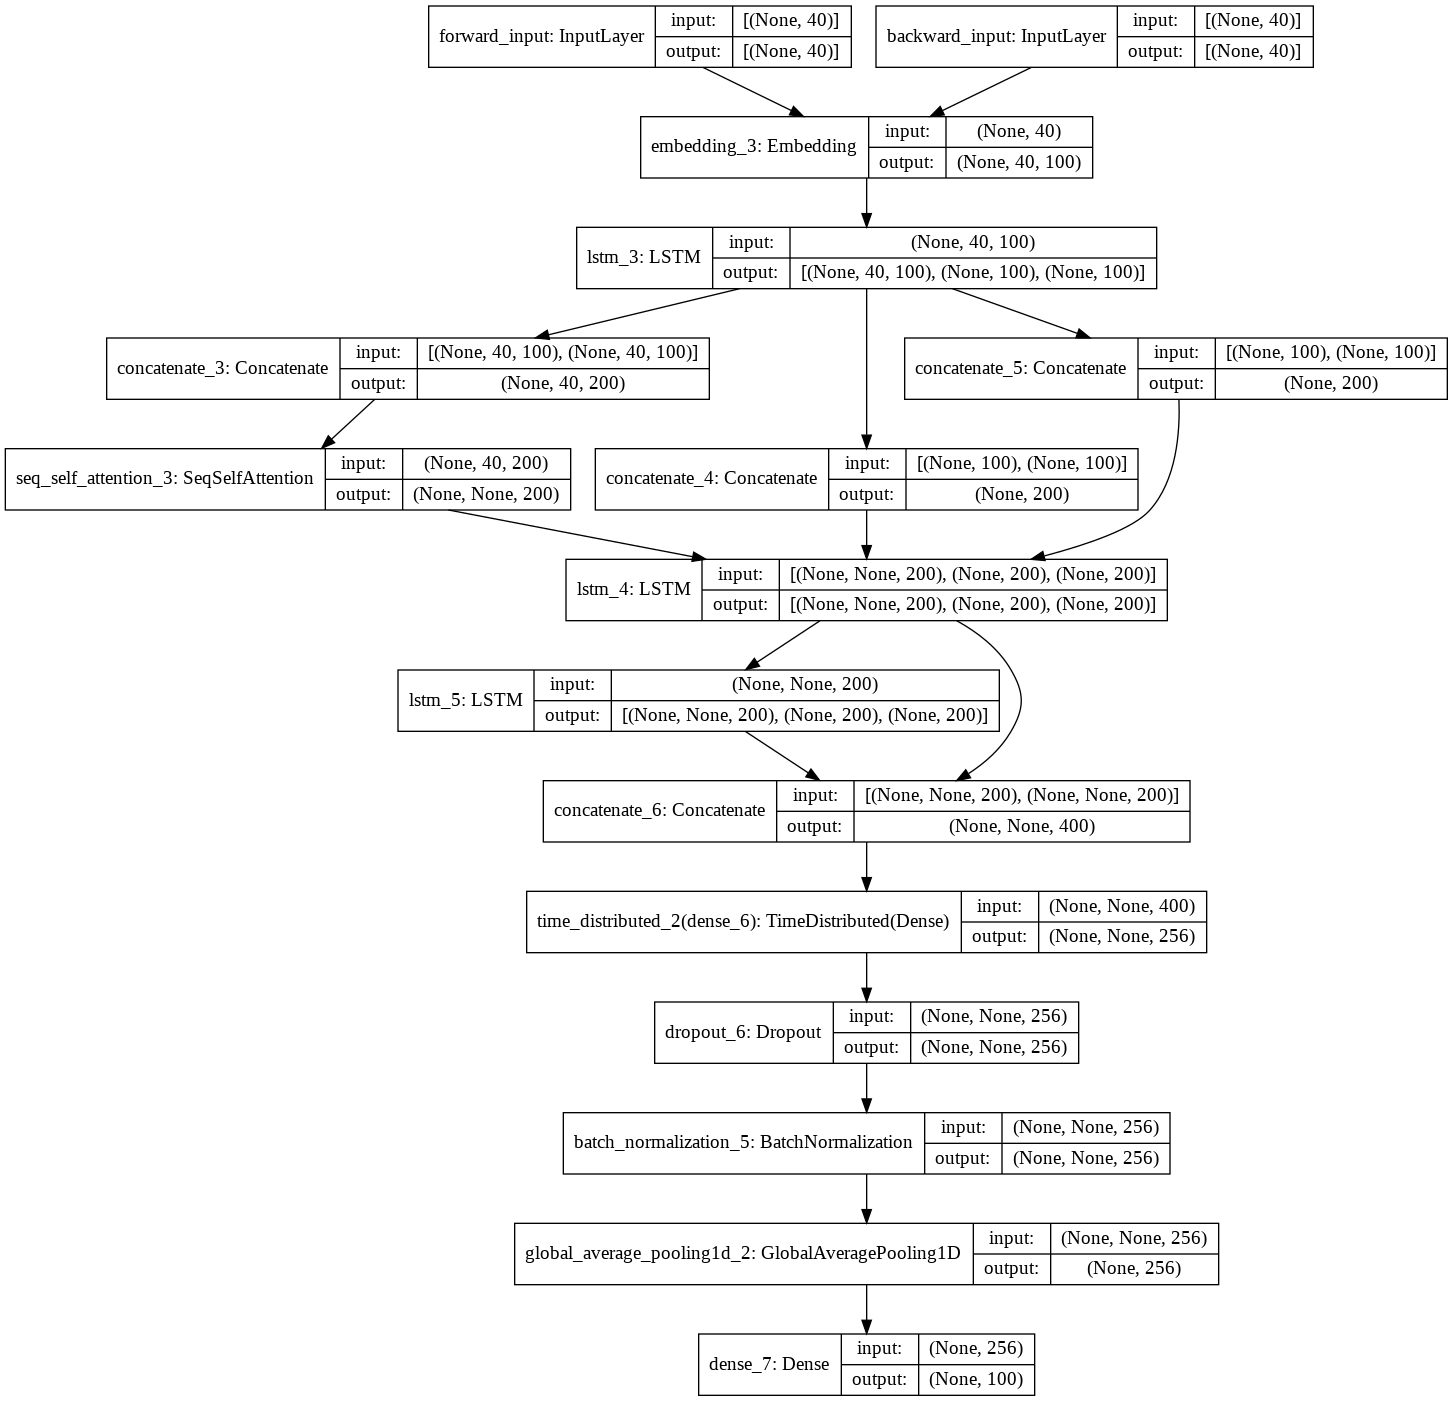

In [35]:
from IPython.display import Image
Image('./Images/model_plot_seq.png')

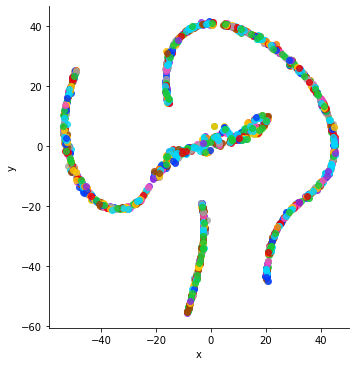

In [36]:
plot_predicted(model_predict_seq, test_target_sense_data)